# CLIP과의 상호작용

CLIP 모델을 다운로드 및 실행하고, 임의 이미지와 텍스트 입력 간의 유사성을 계산하고, 제로샷 이미지 분류를 수행하는 방법을 보여줍니다.

### Colab 에서 실행

In [1]:
# GitHub에서 openai의 CLIP 리포지토리를 직접 설치합니다.
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-nxd1arbl
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-nxd1arbl
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=2bffaa44462f176282e4b4be04f4d826411b1c22a07ce94c597e837055d2c053
  Stored in directory: /tmp/pip-ephem-wheel-cache-ovjn3zmp/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [2]:
import numpy as np
import torch

# 모델 로딩

`clip.available_models()`는 사용 가능한 CLIP 모델의 이름을 나열합니다.

In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
# CLIP 모델 및 전처리 함수를 로드합니다. "ViT-B/32"는 CLIP의 모델 아키텍처를 지정합니다.
model, preprocess = clip.load("ViT-B/32")

# 모델을 GPU로 옮기고 평가 모드로 설정합니다.
model.cuda().eval()

# 모델의 입력 해상도, 문맥 길이, 어휘 크기 정보를 가져옵니다.
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

# 모델의 파라미터 수, 입력 해상도, 문맥 길이, 어휘 크기를 출력합니다.
print("모델 파라미터 수:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("입력 해상도:", input_resolution)
print("컨텍스트 길이:", context_length)
print("어휘 크기:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 58.5MiB/s]


모델 파라미터 수: 151,277,313
입력 해상도: 224
컨텍스트 길이: 77
어휘 크기: 49408


# 이미지 전처리

모델이 기대하는 이미지 해상도에 맞게 입력 이미지의 크기를 조정하고 가운데 부분을 자릅니다. 그 전에 데이터 세트 평균과 표준 편차를 사용하여 픽셀 강도를 정규화합니다.

`clip.load()`의 두 번째 반환 값에는 이 사전 처리를 수행하는 torchvision `Transform`이 포함되어 있습니다.

    - Resize - 이미지를 크기 224로 리사이즈합니다.   
    - CenterCrop - 리사이즈된 이미지의 중심을 기준으로 224 x 224 크기로 자르기를 수행  
    - _convert_image_to_rgb - 이미지를 RGB 형식으로 변환  
    - ToTensor - 이미지를 **텐서(tensor)**로 변환. 이때 픽셀 값은 [0, 255] 범위에서 [0, 1] 범위로 정규화.  
    - Normalize - 각 채널(R, G, B)에 대해 **평균(mean)**과 **표준편차(std)**를 사용하여 픽셀 값의 범위를 조정



In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x79bb7ef0aac0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# 텍스트 전처리

`clip.tokenize()`를 사용하여 대소문자를 구분하지 않는 토크나이저를 사용합니다. 기본적으로 출력은 77개의 토큰 길이가 되도록 채워지며, 이는 CLIP 모델이 예상하는 것입니다.

In [6]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# 입력 이미지 및 텍스트 설정

8개의 예시 이미지와 해당 텍스트 설명을 모델에 제공하고 해당 feature 간의 유사성을 비교할 것입니다.

토크나이저는 대소문자를 구분하지 않으며 적절한 텍스트 설명을 자유롭게 제공할 수 있습니다.

<img src="https://i.imgur.com/HmfDS6g.png" width=600 />

In [9]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import OrderedDict
import torch

skimage.data.download_all()

In [23]:
# Jupyter Notebook 환경에서 시각화한 그래프나 이미지가 더욱 선명하게 출력되도록 하는 설정
%config InlineBackend.figure_format = 'retina'

# skimage 내의 이미지들을 prompt engineering 하여 저장 (파일명: 파일명을 포함한 문장)
descriptions = {
    "page": "This is a page of text about segmentation",
    "chelsea": "This is a facial photo of a tabby cat",
    "astronaut": "This is a portrait of an astronaut with the American flag",
    "rocket": "This is a rocket standing on a launchpad",
    "motorcycle_right": "This is a red motorcycle standing in a garage",
    "camera": "This is a person looking at a camera on a tripod",
    "horse": "This is a black-and-white silhouette of a horse",
    "coffee": "This is a cup of coffee on a saucer"
}

In [24]:
skimage.data_dir

'/root/.cache/scikit-image/0.25.2/data'

In [25]:
# 원본 이미지와 처리된 이미지, 그리고 텍스트를 저장하기 위한 리스트를 초기화합니다.
original_images = []
images = []
texts = []

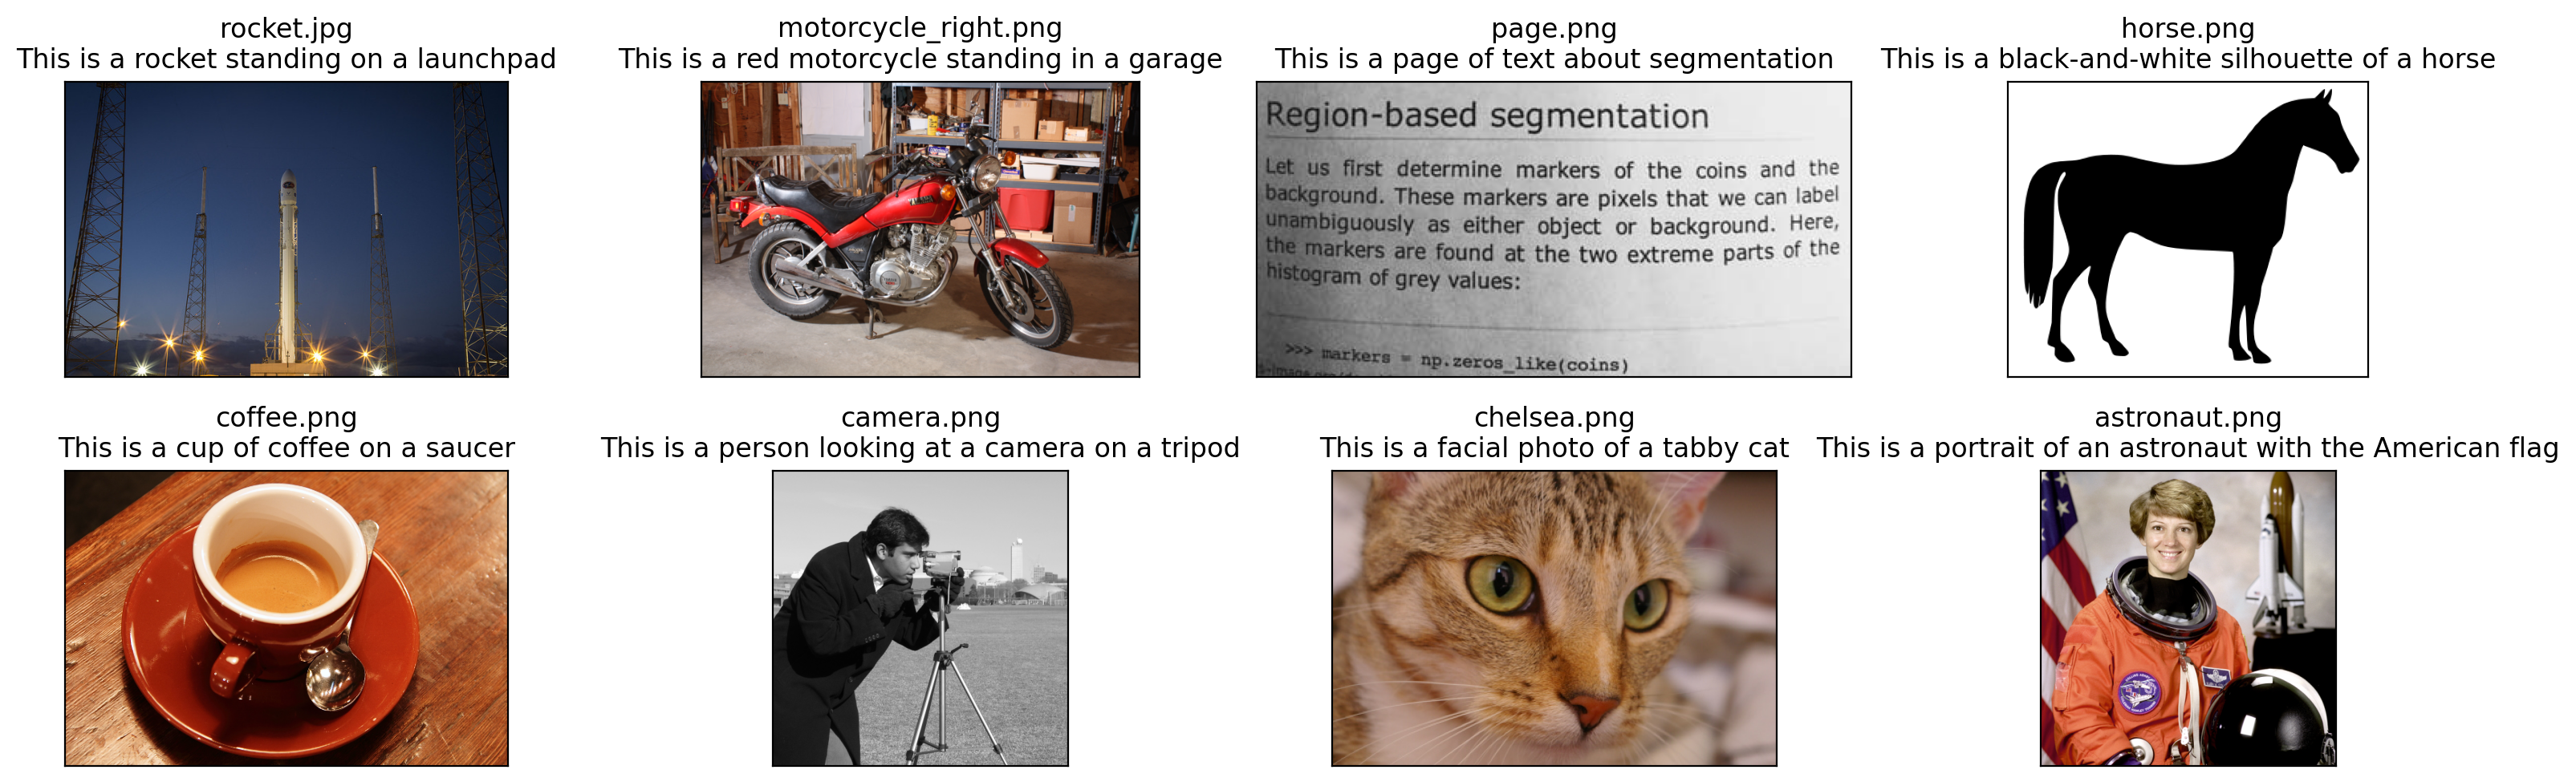

In [26]:
plt.figure(figsize=(16, 5))

# skimage의 데이터 디렉토리에서 .png 또는 .jpg로 끝나는 모든 파일을 반복하여 처리합니다.
for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    # 파일명에서 확장자를 제거하여 이미지의 이름을 얻습니다.
    name = os.path.splitext(filename)[0]

    # 설명이 없는 이미지는 무시합니다.
    if name not in descriptions:
        continue

    # 이미지를 열어 RGB 포맷으로 변환합니다.
    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    # 현재 처리중인 이미지를 서브플롯으로 추가하고, 제목과 함께 그림을 그립니다.
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    # 원본 이미지, 전처리된 이미지, 그리고 해당 이미지의 설명을 각각의 리스트에 추가합니다.
    original_images.append(image)   # 원본 이미지 저장
    images.append(preprocess(image))   # 전처리된 이미지 저장
    texts.append(descriptions[name])    # 이미지 파일명에 해당하는 text 저장

plt.tight_layout()

## feature 생성

이미지를 벡터화하고, 각 텍스트 입력을 토큰화하고, 모델의 순방향 전파를 실행하여 이미지와 텍스트 feature를 얻습니다.

In [27]:
# 이미지 리스트를 numpy 배열로 변환한 후, 이를 파이토치 텐서로 변환후 GPU로 전송
image_input = torch.tensor(np.stack(images)).cuda()

# 이미지에 대한 설명들 앞에 "This is "를 추가한 후, CLIP의 tokenize 함수를 사용하여 텍스트 토큰을 생성
text_tokens = clip.tokenize([desc for desc in texts]).cuda()
text_tokens[0]

tensor([49406,   589,   533,   320,  8383,  2862,   525,   320, 31168,  7601,
        49407,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], device='cuda:0',
       dtype=torch.int32)

토큰화가 잘 되었는지 원래의 text 를 복원하여 확인합니다.

In [28]:
from clip.simple_tokenizer import SimpleTokenizer
# CLIP에서 사용하는 토크나이저 로드
tokenizer = SimpleTokenizer()

# text_tokens의 첫 번째 항목을 detokenize
detokenized_text = tokenizer.decode(text_tokens[0].cpu().numpy())

print(detokenized_text)

<|startoftext|>this is a rocket standing on a launchpad <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [29]:
with torch.no_grad():
    # 이미지 입력을 모델에 전달하여 이미지 특성을 추출
    image_features = model.encode_image(image_input).float()

    # 텍스트 토큰을 모델에 전달하여 텍스트 특성을 추출
    text_features = model.encode_text(text_tokens).float()

# 코사인 유사도 계산을 위해 8개의 image feature shape 과 text feature shape 이 동일한지 확인
image_features.shape, text_features.shape

(torch.Size([8, 512]), torch.Size([8, 512]))

## 코사인 유사도 계산

feature를 정규화하고 각 쌍의 내적을 계산합니다.  
특성 vetor를 정규화 하면 길이가 1 이 되므로 벡터의 크기를 신경 쓰지 않고 방향 정보만 사용하게 됩니다.

In [30]:
# 이미지/text 특성의 L2 Norm(유클리드 노름)을 계산하여 특성 벡터를 정규화합니다.
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# 텍스트 특성과 이미지 특성 사이의 유사성을 계산하기 위해 내적(dot product) 연산을 수행합니다.
# 결과적으로, 이 유사성 행렬의 각 요소는 특정 텍스트 설명과 이미지 간의 유사성 점수를 나타냅니다.
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

image_features.shape, text_features.shape, similarity.shape

(torch.Size([8, 512]), torch.Size([8, 512]), (8, 8))

사전 학습된 CLIP 모델이 image feature 와 text feature 간의 유사도를 정확히 반영하는지 시각화하여 확인

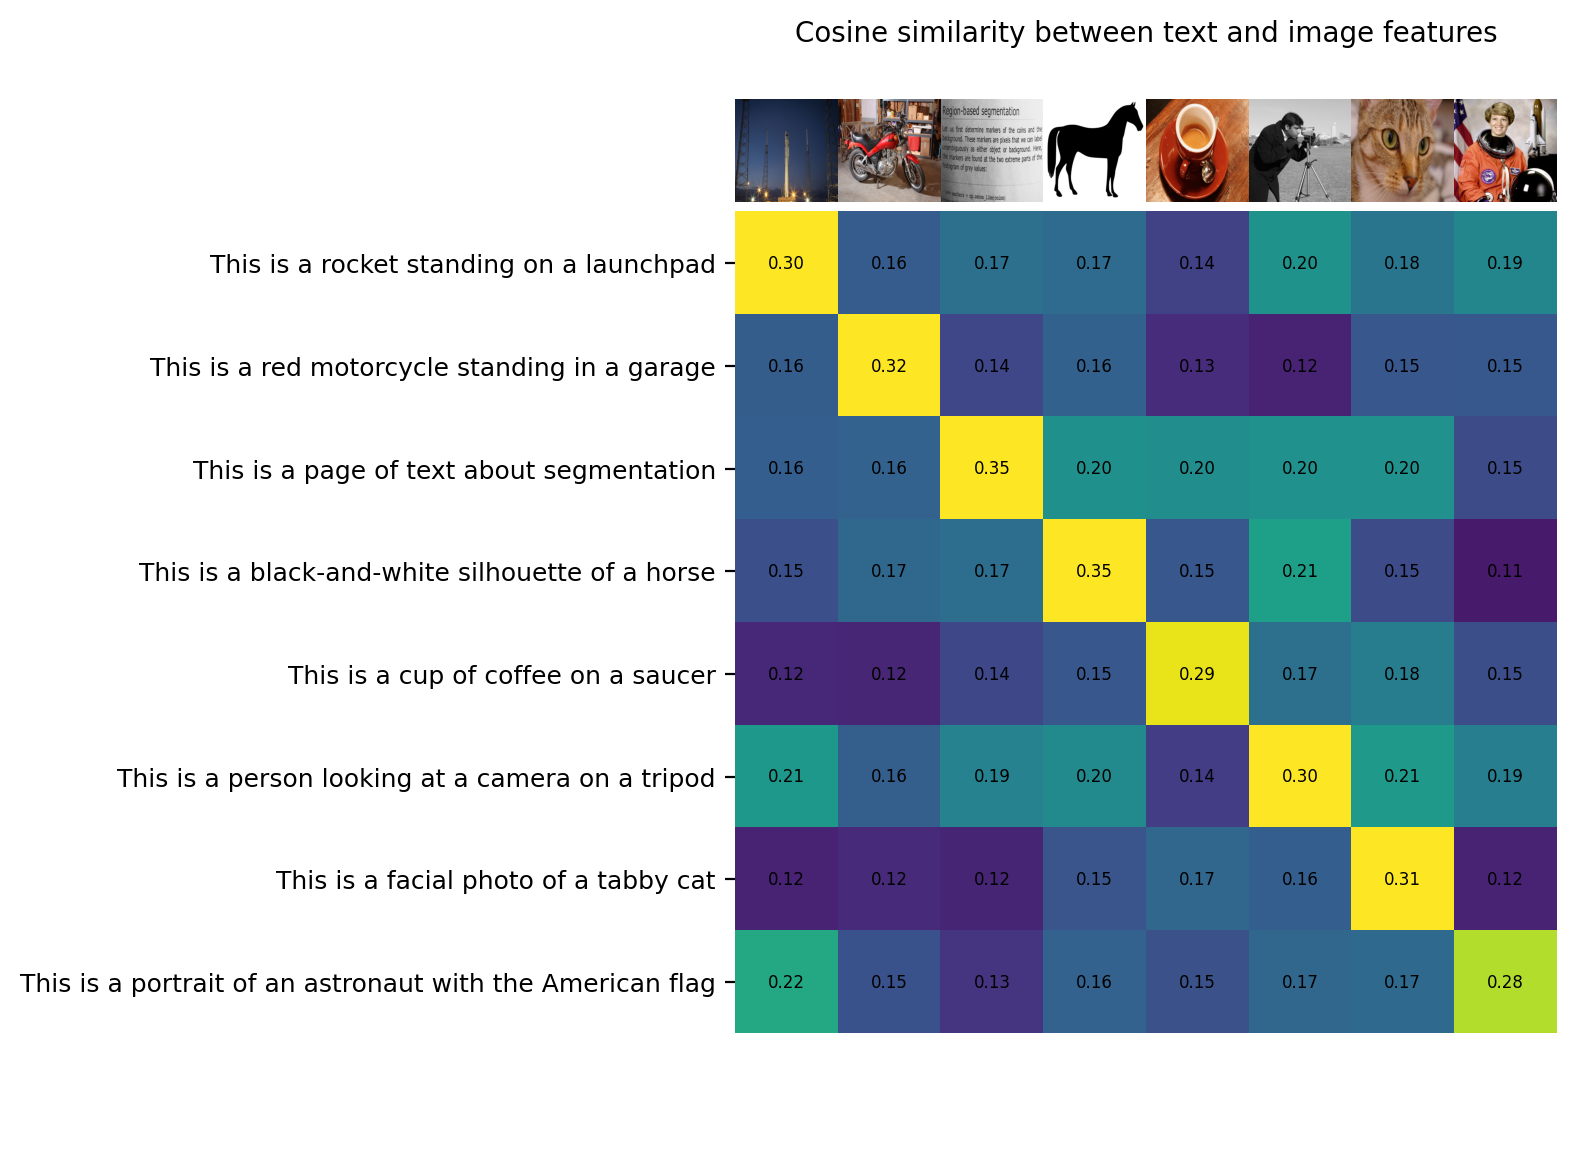

In [31]:
count = len(descriptions)

plt.figure(figsize=(10, 7))

# 그래프 제목 설정
plt.title("Cosine similarity between text and image features", size=10)

# 코사인 유사도 매트릭스를 색상으로 시각화
plt.imshow(similarity, vmin=0.1, vmax=0.3)   # 0.1 이하의 값은 가장 낮은 색상, 0.3 이상의 값은 가장 높은 색상으로 표시
plt.yticks(range(count), texts, fontsize=9)   # y축에 텍스트 라벨을 추가하고 폰트 크기를 9로 설정
plt.xticks([])   # x축 눈금을 표시하지 않음

# 유사도 매트릭스의 각 셀에 해당하는 값을 표시
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=6)

# x축과 y축의 범위 설정
plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

# 이미지를 유사도 매트릭스 위로 표시
for i, image in enumerate(original_images):
    # 플롯의 특정 부분에 이미지를 배치
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

# 그래프 주변의 테두리 제거
for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)